# Where to open new restaurant in Sasebo
This is **Applied Data Science Capstone** project

I predict where looks good for opening new restaurant by using population data.  
**Sasebo** is located at West edge of **Japan**. There are many delicious food and nice landscape. I omit it in this notebook, but if you interested in it, please look at [my report](https://github.com/muchojp/Coursera_Applied_Data_Science_Capstone/blob/master/week5/Where_to_open_your_new_restaurant_in_Sasebo_3.pdf) or search web.

## import packages

In [1]:
import pandas as pd
import numpy as np

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

import requests
import json

import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

Set the constant

In [2]:
latitude = 33.17
longitude = 129.78
LIMIT = 100 # limit of number of venues returned by Foursquare API

## Data and Preprocess
Load csv file ( Data source is [here](https://nlftp.mlit.go.jp/cgi-bin/isj/dls/_choose_files.cgi) )  
In order to focus on the Southeast side of Sasebo and reduce data, I did following preprocess

In [3]:
path = '../data/42202_2017.csv'
df0 = pd.read_csv(path,encoding='cp932')

In [4]:
df = df0[['緯度', '経度', '大字町丁目名', '大字町丁目コード']]
df = df.rename(columns={'緯度':'Latitude', '経度':'Longitude', '大字町丁目名':'Neighborhood', '大字町丁目コード':'code'})
df = df[(df.Latitude > df.Latitude.quantile(0.5) - 2*df.Latitude.std()) & (df.Latitude < df.Latitude.quantile(0.5) + 0.5*df.Latitude.std())]
df = df[(df.Longitude > df.Longitude.quantile(0.5)) & (df.Longitude < df.Longitude.quantile(0.5) + 2*df.Longitude.std())]

## Methodology
- Using the Foursquare API and position data of towns, search what is located near and in the town.
- Cluster the towns by using k-means and find out the features.
- Using folium and population data, predict where is suitable for opening new restaurant.

#### Define Foursquare Credentials and Version

In [5]:
CLIENT_ID = 'KB3VO3CRMDJWEAPZFPRYLCPFWYO4HDBKBB2LAIHHS3RSOR0F' # your Foursquare ID
CLIENT_SECRET = 'FD0EMM4WEJPXECFGIRBMGZVBIXMKLMS3PW0KOLYITX5UBEO1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KB3VO3CRMDJWEAPZFPRYLCPFWYO4HDBKBB2LAIHHS3RSOR0F
CLIENT_SECRET:FD0EMM4WEJPXECFGIRBMGZVBIXMKLMS3PW0KOLYITX5UBEO1


In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,radius,LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        """# return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            name, 
            lat, 
            lng,  
            v['venue']['categories'][0]['name']) for v in results])"""
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Explore Neighborhoods in Sasebo

#### Let's create a function to repeat the same process to all the neighborhoods in Sasebo
Now write the code to run the above function on each neighborhood and create a new dataframe called *manhattan_venues*.

In [7]:
# type your answer here
df_venues = getNearbyVenues(names=df['Neighborhood'],latitudes=df['Latitude'],longitudes=df['Longitude'])

赤木町
有福町
稲荷町
浦川内町
上原町
江上町
烏帽子町
大岳台町
大宮町
沖新町
奥山町
卸本町
勝海町
川谷町
木風町
口の尾町
黒髪町
桑木場町
心野町
小佐世保町
小舟町
権常寺一丁目
権常寺町
崎岡町
崎辺町
桜木町
指方町
里美町
早苗町
塩浸町
潮見町
重尾町
下宇戸町
下の原町
十郎新町
城間町
白木町
白岳町
新替町
陣の内町
須佐町
須田尾町
瀬戸越一丁目
瀬戸越二丁目
大黒町
大塔町
高梨町
高花町
田代町
田の浦町
天神一丁目
天神二丁目
天神三丁目
天神四丁目
天神五丁目
戸ヶ倉町
長畑町
中原町
早岐一丁目
早岐二丁目
早岐三丁目
ハウステンボス町
南風崎町
花高一丁目
花高二丁目
花高三丁目
花高四丁目
針尾北町
針尾中町
針尾西町
針尾東町
日宇町
東浜町
東山町
平松町
広田一丁目
広田二丁目
広田三丁目
広田四丁目
広田町
福石町
藤原町
松原町
三川内本町
宮津町
もみじが丘町
山祇町
山手町
大和町
矢峰町
柚木町
横手町
若竹台町
若葉町


## Analyze Each Neighborhood

In [8]:
# one hot encoding
df_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_onehot['Neighborhood'] = df_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

df_onehot.shape

(417, 92)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [9]:
df_grouped = df_onehot.groupby('Neighborhood').mean().reset_index()
df_grouped.shape

(68, 92)

#### Let's print each neighborhood along with the top 5 most common venues

In [31]:
num_top_venues = 5

for hood in df_grouped['Neighborhood']:
    #print("----"+hood+"----")
    temp = df_grouped[df_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    #print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    #print('\n')

#### Let's put that into a *pandas* dataframe
First, let's write a function to sort the venues in descending order.

In [11]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [93]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = df_grouped['Neighborhood']

for ind in np.arange(df_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,もみじが丘町,Convenience Store,Grocery Store,Dessert Shop,Toy / Game Store,Bakery,Noodle House,Electronics Store,Department Store,Diner,Discount Store
1,ハウステンボス町,Theme Park,Hotel,Athletics & Sports,Restaurant,Convenience Store,Noodle House,Resort,Café,Steakhouse,Gift Shop
2,三川内本町,Convenience Store,Arts & Crafts Store,Udon Restaurant,Train Station,Burger Joint,Farmers Market,Department Store,Dessert Shop,Diner,Discount Store
3,中原町,Park,Lake,Yoshoku Restaurant,Farmers Market,Department Store,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop
4,勝海町,Convenience Store,Bus Station,Motorcycle Shop,Dumpling Restaurant,Bus Stop,Sushi Restaurant,Fried Chicken Joint,Food Court,Dessert Shop,Diner


## Cluster Neighborhoods
Run *k*-means to cluster the neighborhood into 5 clusters.

In [94]:
# set number of clusters
kclusters = 5

df_grouped_clustering = df_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 1, 2, 1, 4, 4, 3, 4, 4])

In [95]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

df_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
df_merged = df_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

df_merged.head() # check the last columns!

,Latitude,Longitude,Neighborhood,code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,33.194758,129.750191,赤木町,422020003000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,33.131600,129.781037,有福町,422020007000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,33.159114,129.736214,稲荷町,422020011000,4.0,Bus Stop,Convenience Store,Dessert Shop,Japanese Restaurant,Noodle House,Yoshoku Restaurant,Diner,Discount Store,Donburi Restaurant,Donut Shop
24,33.114927,129.811383,浦川内町,422020025000,4.0,Motel,Yoshoku Restaurant,Farmers Market,Department Store,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop,Dumpling Restaurant
25,33.152388,129.805696,上原町,422020026000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are some rows which contain NaN and the others' 'Cluster Labels' are float. I remove NaN rows and cast float into int.

In [96]:
df_merged.dropna(axis=0, inplace=True)
df_merged['Cluster Labels'] = df_merged['Cluster Labels'].astype(int)

## Examine Clusters
I examined each cluster and determine the discriminating venue categories that distinguish each cluster. 

#### Cluster 1
They have Cafe.

In [97]:
df_merged.loc[df_merged['Cluster Labels'] == 0, df_merged.columns[[2] + list(range(5, df_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
51,大岳台町,Cosmetics Shop,Restaurant,Café,Yoshoku Restaurant,Department Store,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop
110,早苗町,Café,Convenience Store,Pharmacy,Yoshoku Restaurant,Deli / Bodega,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop
218,花高二丁目,Café,Convenience Store,Grocery Store,Food & Drink Shop,Electronics Store,Department Store,Dessert Shop,Diner,Discount Store,Donburi Restaurant
227,日宇町,Café,Yoshoku Restaurant,Farmers Market,Department Store,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop,Dumpling Restaurant


#### Cluster 2
They have Convenience Store.

In [98]:
df_merged.loc[df_merged['Cluster Labels'] == 1, df_merged.columns[[2] + list(range(5, df_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
64,勝海町,Convenience Store,Bus Station,Motorcycle Shop,Dumpling Restaurant,Bus Stop,Sushi Restaurant,Fried Chicken Joint,Food Court,Dessert Shop,Diner
107,桜木町,Convenience Store,Trail,Park,Bus Stop,Electronics Store,Department Store,Dessert Shop,Diner,Discount Store,Donburi Restaurant
108,指方町,Convenience Store,Shop & Service,Japanese Restaurant,Farmers Market,Department Store,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop
164,瀬戸越一丁目,Convenience Store,Supermarket,Historic Site,Athletics & Sports,Fast Food Restaurant,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop
165,瀬戸越二丁目,Convenience Store,Japanese Restaurant,Burger Joint,Sushi Restaurant,Gift Shop,Furniture / Home Store,Department Store,Dessert Shop,Diner,Discount Store
170,大黒町,Convenience Store,Gym,Farmers Market,Department Store,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop,Dumpling Restaurant
174,高梨町,Hotel,Shrine,Park,Convenience Store,Auto Workshop,Farmers Market,Dessert Shop,Diner,Arts & Crafts Store,Discount Store
187,天神一丁目,Department Store,Memorial Site,Convenience Store,Park,Burger Joint,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop
189,天神三丁目,Convenience Store,Department Store,Sake Bar,Bakery,Farmers Market,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop
190,天神四丁目,Convenience Store,Diner,Cosmetics Shop,Department Store,Dessert Shop,Discount Store,Donburi Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store


#### Cluster 3
They have Park, and wide range of population

In [114]:
df_merged.loc[df_merged['Cluster Labels'] == 2, df_merged.columns[[2] + list(range(5, df_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,烏帽子町,Park,Bus Stop,Yoshoku Restaurant,Farmers Market,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop,Dumpling Restaurant
82,黒髪町,Coffee Shop,Park,Candy Store,Yoshoku Restaurant,Deli / Bodega,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop
96,小佐世保町,Park,Shrine,Yoshoku Restaurant,Electronics Store,Department Store,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop
102,権常寺町,Restaurant,Diner,Park,Electronics Store,Deli / Bodega,Department Store,Dessert Shop,Discount Store,Donburi Restaurant,Donut Shop
106,崎辺町,Park,Bus Stop,Yoshoku Restaurant,Farmers Market,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop,Dumpling Restaurant
149,須佐町,Hotel,Park,Shrine,Electronics Store,Department Store,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop
178,田代町,Bus Stop,Yoshoku Restaurant,Farmers Market,Department Store,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop,Dumpling Restaurant
203,中原町,Park,Lake,Yoshoku Restaurant,Farmers Market,Department Store,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop
220,花高四丁目,Park,Bus Stop,Yoshoku Restaurant,Farmers Market,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop,Dumpling Restaurant
230,東山町,Park,Grocery Store,Bus Stop,Yoshoku Restaurant,Farmers Market,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop


#### Cluster 4
They located near intersection.

In [100]:
df_merged.loc[df_merged['Cluster Labels'] == 3, df_merged.columns[[2] + list(range(5, df_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
113,塩浸町,Intersection,Yoshoku Restaurant,Fast Food Restaurant,Department Store,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop,Dumpling Restaurant
144,新替町,Intersection,Yoshoku Restaurant,Fast Food Restaurant,Department Store,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop,Dumpling Restaurant
182,田の浦町,Intersection,Italian Restaurant,Yoshoku Restaurant,Farmers Market,Department Store,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop
223,針尾中町,Intersection,Yoshoku Restaurant,Fast Food Restaurant,Department Store,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop,Dumpling Restaurant
225,針尾東町,Intersection,Yoshoku Restaurant,Fast Food Restaurant,Department Store,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop,Dumpling Restaurant


#### Cluster 5
They have a variety of store and are located near the main road.

In [101]:
df_merged.loc[df_merged['Cluster Labels'] == 4, df_merged.columns[[2] + list(range(5, df_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,稲荷町,Bus Stop,Convenience Store,Dessert Shop,Japanese Restaurant,Noodle House,Yoshoku Restaurant,Diner,Discount Store,Donburi Restaurant,Donut Shop
24,浦川内町,Motel,Yoshoku Restaurant,Farmers Market,Department Store,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop,Dumpling Restaurant
53,大宮町,Kids Store,Bus Stop,Video Store,Restaurant,Thrift / Vintage Store,Shopping Mall,Electronics Store,Convenience Store,Sporting Goods Shop,Deli / Bodega
55,沖新町,Noodle House,Department Store,Pastry Shop,Shopping Mall,Burger Joint,Electronics Store,Dessert Shop,Diner,Discount Store,Donburi Restaurant
60,卸本町,Convenience Store,Restaurant,Thrift / Vintage Store,Italian Restaurant,Pizza Place,Discount Store,Electronics Store,Japanese Restaurant,Bus Stop,Bus Station
74,木風町,Italian Restaurant,Bakery,Yoshoku Restaurant,Fast Food Restaurant,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop,Dumpling Restaurant
80,口の尾町,Golf Course,Yoshoku Restaurant,Farmers Market,Department Store,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop,Dumpling Restaurant
101,権常寺一丁目,Train Station,Convenience Store,Yoshoku Restaurant,Tea Room,Food & Drink Shop,Japanese Curry Restaurant,Noodle House,Pharmacy,Restaurant,Supermarket
105,崎岡町,Noodle House,Japanese Restaurant,Yoshoku Restaurant,Farmers Market,Department Store,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop
114,潮見町,Hotel,Convenience Store,Train Station,Japanese Restaurant,Coffee Shop,Pharmacy,Diner,Ice Cream Shop,Burger Joint,Restaurant


## mapping
Load excel file and preprocess

In [102]:
df_cho = pd.read_excel('../data/sasebotoshiken.xlsx')
df_cho.columns = ['KEY_CODE', 'population', 'Neighborhood', 'man', 'woman', 'households']
df_cho = df_cho[df_cho['population'] != '-']
df_cho['population'] = df_cho['population'].astype(int)
df_cho['households'] = df_cho['households'].astype(int)

Load geojson file

In [103]:
world_geo = r'../data/sasebotoshiken.geojson' # geojson file

In [104]:
#JSON ファイルの読み込み
f = open(world_geo, 'r', encoding="utf-8_sig")
json_data = json.load(f)

### Choropleth map with Population
In order to reduce storage volume, I comment out plotting cell. Before you run cells below, remove the **""" """**.

In [105]:
# df_cho = df_cho[['Neighborhood', 'population']]
df_cho1 = df_cho[['KEY_CODE', 'population']]
df_cho1 = df_cho1[df_cho1['population'] != '-']
df_cho1['population'] = df_cho1['population'].astype(int)
df_cho1['KEY_CODE'] = df_cho1['KEY_CODE'].astype(str)
df_cho1 = df_cho1[df_cho1['population']>0]

C:\Users\yuuki\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [134]:
"""venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around Ecco


# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
folium.Choropleth(
    geo_data=json.load(open(world_geo, encoding='utf-8_sig')),
    data=df_cho1,
    columns=['KEY_CODE', 'population'],
    key_on='feature.properties.KEY_CODE',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population of Sasebo'
).add_to(venues_map)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighborhood'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(venues_map)

venues_map.save('map1.html')
# display map
venues_map"""

"venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around Ecco\n\n\n# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013\nfolium.Choropleth(\n    geo_data=json.load(open(world_geo, encoding='utf-8_sig')),\n    data=df_cho1,\n    columns=['KEY_CODE', 'population'],\n    key_on='feature.properties.KEY_CODE',\n    fill_color='YlOrRd', \n    fill_opacity=0.7, \n    line_opacity=0.2,\n    legend_name='Population of Sasebo'\n).add_to(venues_map)\n\n# set color scheme for the clusters\nx = np.arange(kclusters)\nys = [i + x + (i*x)**2 for i in range(kclusters)]\ncolors_array = cm.rainbow(np.linspace(0, 1, len(ys)))\nrainbow = [colors.rgb2hex(i) for i in colors_array]\n\n# add markers to the map\nmarkers_colors = []\nfor lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighborhood'], df_merged['Cluster Labels']):\n    label = folium.Popup(str(poi) + ' Cluster ' + str(

### Choropleth map with households

In [108]:
# df_cho = df_cho[['Neighborhood', 'population']]
df_cho2 = df_cho[['KEY_CODE', 'households']]
df_cho2 = df_cho2[df_cho2['households'] != '-']
df_cho2['households'] = df_cho2['households'].astype(int)
df_cho2['KEY_CODE'] = df_cho2['KEY_CODE'].astype(str)
df_cho2 = df_cho2[df_cho2['households']>0]

C:\Users\yuuki\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [135]:
"""venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around Ecco


# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
folium.Choropleth(
    geo_data=json.load(open(world_geo, encoding='utf-8_sig')),
    data=df_cho2,
    columns=['KEY_CODE', 'households'],
    key_on='feature.properties.KEY_CODE',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population of Sasebo'
).add_to(venues_map)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighborhood'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(venues_map)

venues_map.save('map2.html')
# display map
venues_map"""

"venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around Ecco\n\n\n# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013\nfolium.Choropleth(\n    geo_data=json.load(open(world_geo, encoding='utf-8_sig')),\n    data=df_cho2,\n    columns=['KEY_CODE', 'households'],\n    key_on='feature.properties.KEY_CODE',\n    fill_color='YlOrRd', \n    fill_opacity=0.7, \n    line_opacity=0.2,\n    legend_name='Population of Sasebo'\n).add_to(venues_map)\n\n# set color scheme for the clusters\nx = np.arange(kclusters)\nys = [i + x + (i*x)**2 for i in range(kclusters)]\ncolors_array = cm.rainbow(np.linspace(0, 1, len(ys)))\nrainbow = [colors.rgb2hex(i) for i in colors_array]\n\n# add markers to the map\nmarkers_colors = []\nfor lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighborhood'], df_merged['Cluster Labels']):\n    label = folium.Popup(str(poi) + ' Cluster ' + str(

### Choropleth map with number of peaple per household

In [110]:
# df_cho = df_cho[['Neighborhood', 'population']]
df_cho3 = df_cho[['KEY_CODE','population', 'households']]
df_cho3 = df_cho3[df_cho3['population'] != '-']
df_cho3 = df_cho3[df_cho3['households'] != '-']
df_cho3['population'] = df_cho3['population'].astype(int)
df_cho3['households'] = df_cho3['households'].astype(int)
df_cho3['KEY_CODE'] = df_cho3['KEY_CODE'].astype(str)
df_cho3['num_of_peaple_per_household'] = df_cho3['population']/df_cho3['households']
df_cho3 = df_cho3[['KEY_CODE', 'num_of_peaple_per_household']]
df_cho3 = df_cho3[df_cho3['num_of_peaple_per_household']<5]

In [133]:
"""venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around Ecco


# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
folium.Choropleth(
    geo_data=json.load(open(world_geo, encoding='utf-8_sig')),
    data=df_cho3,
    columns=['KEY_CODE', 'num_of_peaple_per_household'],
    key_on='feature.properties.KEY_CODE',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population of Sasebo'
).add_to(venues_map)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighborhood'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(venues_map)
    
venues_map.save('map3.html')
# display map
venues_map"""

"venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around Ecco\n\n\n# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013\nfolium.Choropleth(\n    geo_data=json.load(open(world_geo, encoding='utf-8_sig')),\n    data=df_cho3,\n    columns=['KEY_CODE', 'num_of_peaple_per_household'],\n    key_on='feature.properties.KEY_CODE',\n    fill_color='YlOrRd', \n    fill_opacity=0.7, \n    line_opacity=0.2,\n    legend_name='Population of Sasebo'\n).add_to(venues_map)\n\n# set color scheme for the clusters\nx = np.arange(kclusters)\nys = [i + x + (i*x)**2 for i in range(kclusters)]\ncolors_array = cm.rainbow(np.linspace(0, 1, len(ys)))\nrainbow = [colors.rgb2hex(i) for i in colors_array]\n\n# add markers to the map\nmarkers_colors = []\nfor lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighborhood'], df_merged['Cluster Labels']):\n    label = folium.Popup(str(poi) + '

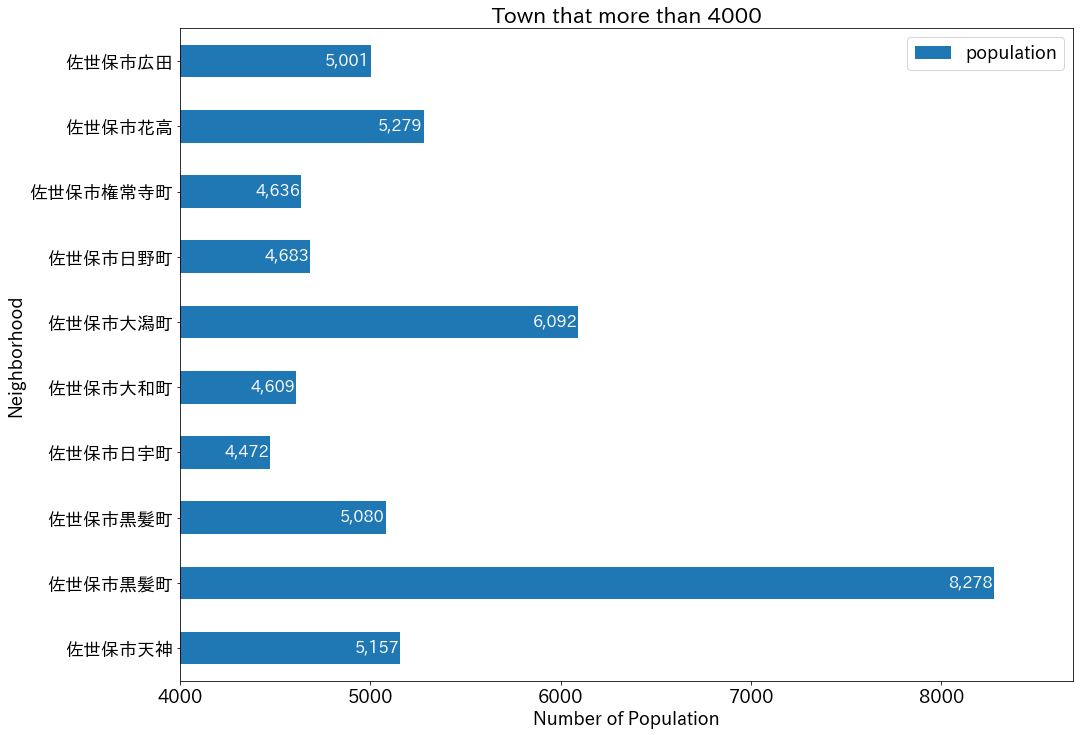

In [130]:
df_cho4 = df_cho[:]
df_cho4 = df_cho4[df_cho4['Neighborhood'].str.startswith('佐世保市')]
df_cho4 = df_cho4[df_cho4['population']>4000]
df_cho4.plot(kind='barh', figsize=(16, 12), x='Neighborhood', y='population')
plt.xlim(4000, )
plt.xlabel('Number of Population')
plt.title('Town that more than 4000')
for index, value in enumerate(df_cho4['population']): 
    label = format(int(value), ',') # format int with commas
    
    # place text at the end of bar (subtracting 47000 from x, and 0.1 from y to make it fit within the bar)
    plt.annotate(label, xy=(value - 240, index - 0.05), fontsize=16,color='white')
plt.savefig('barplot.png')    
plt.show()

![map1](https://github.com/muchojp/Coursera_Applied_Data_Science_Capstone/blob/master/week5/image/map1_processed.png)

## Discussion
- First, we can find that there are population gap betweens towns. This means that They have different features.  
- In addition, peaple per household become less near the main road.  
- Let's focus on cluster3(blue marker). I group up them into 3 group: Northeast, Southeast, and other group. First, other group is unclear. Second, northeast group has very large area and huge population. However, it does not have Super Market or Convenience Store. It looks like good place to start new restaurant. One tip is, because they have very large area, we have to search carefully estate and traffic volume. Southeast group have less population than Northeast group, but it is easy to search around because they have small area. 

## Conclusion
It become easy to be able to predict where is suited for newly opening restaurant by using town position data, polygon data, and plotting a bar chart and choropleth map. However, this is not enough to decide the place. I have to take count on other factors: land price or rent price, utility charges, average salary of the town, convenience of transportation, and so on. It is important to search from other aspects. Then I have to decide where is the best.  

## Preference
- 西九州させぼ広域都市圏オープンデータポータルサイト https://odcs.bodik.jp/sasebo-toshiken/
- 国土交通省 国土数値情報、位置参照情報、国土調査（土地分類・水基本調査）成果　https://nlftp.mlit.go.jp/index.html